In [1]:
import os
os.chdir('/Volumes/Transcend/00unzip')
import sys
import json
import ijson
import nltk
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
#get 5K for testing

f = open('/Volumes/Transcend/00unzip/gab_posts_jan_2018.json')
objects = ijson.items(f,'actuser.username')

chunk=[]
username=[]
body=[]
ts=[]

i = 0
for a in f:
    line = json.loads(a)
    username.append(line['actuser']['username'])
    body.append(line['post']['body'])
    ts.append(line['published_at'])
    i = i+1
    if i > 100000:
        break
                      
df_original = pd.DataFrame(
    {'username': username,
     'body': body,
     'ts': ts
    })
df = df_original

In [6]:
df.to_csv('gab_snippet.csv')
#100K record is ~18mb

### Input

In [7]:
### preprocessing/ remove url
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

def clean_txt(txt):
    #remove_url
    txt = re.sub(r'^https?:\/\/.*[\r\n]*', '', txt, flags=re.MULTILINE)
    #same lettercase
    txt = txt.lower() 
    #remove stopwords
    txt = ' '.join(word for word in txt.split() if word not in STOPWORDS)
    return txt

df['body'] = df['body'].apply(clean_txt)

In [9]:
count_vectorizer = CountVectorizer(stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None)
cnt = count_vectorizer.fit_transform(df.body)
cnt_feature_names = count_vectorizer.get_feature_names()

In [10]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=10, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df.body)

### SVD

In [11]:
from sklearn.decomposition import TruncatedSVD
lsa = TruncatedSVD(2, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(tfidf)
dtm_lsa.shape

(100001, 2)

In [12]:
import numpy as np
tfidf_output = pd.DataFrame(np.c_[dtm_lsa, df.body])
tfidf_output.head()
tfidf_output.to_csv('tfidf_output.csv')

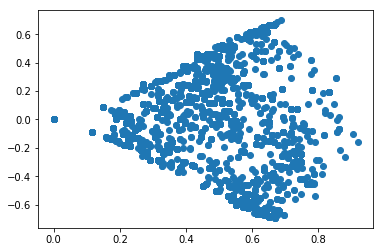

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(dtm_lsa[:,0], dtm_lsa[:,1],'o')

### doc2vec

In [16]:
import gensim
def read_corpus(documents):
    for i, text in enumerate(documents):
        yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(text), [i])
        
train_corpus = list(read_corpus(df.body))

In [17]:
#train the model
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=55)
model.build_vocab(train_corpus)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
doc_vectors = model.docvecs.vectors_docs
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(doc_vectors)
plt.scatter(X_2d[:,0], X_2d[:,1])

In [ ]:
num_clusters = 10
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( doc_vectors )

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()
plt.title('MNIST with PCA')